На основании датасета для каждого покупателя вычислите агрегаты, отражающие индивидуальные предпочтения и траты.
Требуемые метрики:

- Предпочитаемый метод оплаты (например, по моде или максимальному обороту).
- Общие траты за весь период наблюдения по покупателю.
- Сумма, потраченная на дополнительные услуги и аксессуары по каждому покупателю.

Ожидается корректная работа кода без ошибок и корректные вычисления по всем клиентам в датасете.

In [36]:
import pandas as pd 
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter

# Задание 1

- Идентификатор клиента: уникальный идентификатор каждого покупателя. Customer ID: Unique identifier for each customer.
- Возраст: возраст покупателя (числовое значение). Age: Age of the customer (numeric)
- Пол: пол покупателя (мужской или женский). Gender: Gender of the customer (Male or Female)
- Участник программы лояльности: да/нет; статус меняется со временем, учитывайте, кто отменил и кто подключился. Loyalty Member: (Yes/No) (Values change by time, so pay attention to who cancelled and who signed up)
- Тип продукта: категория электронного товара (например, смартфон, ноутбук, планшет). Product Type: Type of electronic product sold (e.g., Smartphone, Laptop, Tablet)
- SKU: уникальный код каждого товара. SKU: a unique code for each product.
- Рейтинг: оценка товара покупателем от 1 до 5 звёзд; пропусков быть не должно. Rating: Customer rating of the product (1-5 stars) (Should have no Null Ratings)
- Статус заказа: состояние заказа (выполнен, отменён). Order Status: Status of the order (Completed, Cancelled)
- Метод оплаты: способ оплаты (например, наличные, кредитная карта, PayPal). Payment Method: Method used for payment (e.g., Cash, Credit Card, Paypal)
- Итоговая сумма: общая стоимость транзакции (число). Total Price: Total price of the transaction (numeric)
- Цена за единицу: стоимость одной единицы товара (число). Unit Price: Price per unit of the product (numeric)
- Количество: число купленных единиц (число). Quantity: Number of units purchased (numeric)
- Дата покупки: дата совершения покупки (формат: YYYY-MM-DD). Purchase Date: Date of the purchase (format: YYYY-MM-DD)
- Тип доставки: выбранный тип доставки (например, стандарт, ускоренная, экспресс). Shipping Type: Type of shipping chosen (e.g., Standard, Overnight, Express)
- Приобретённые дополнения: список дополнительных позиций (например, аксессуары, расширенная гарантия). Add-ons Purchased: List of any additional items purchased (e.g., Accessories, Extended Warranty)
- Сумма дополнений: общая стоимость приобретённых дополнений (число). Add-on Total: Total price of add-ons purchased (numeric)

In [2]:
df = pd.read_csv('Electronic_sales_Sep2023-Sep2024.csv')
df['Purchase Date'] = pd.to_datetime(df['Purchase Date'], format='%Y-%m-%d')

Конечная цена с учетом допов работаем с ней

In [3]:
df["Total_Spent_Row"] = df['Total Price'] + df['Add-on Total']

Оставляем только завершенные заказы

In [4]:
df = df[df['Order Status'] == 'Completed']

## Предпочитаемый метод оплаты (например, по моде или максимальному обороту).

In [5]:
df['Payment Method'] = df['Payment Method'].str.strip().str.lower()

In [6]:
df.groupby('Payment Method', as_index=False)['Total_Spent_Row'].agg({'sum': 'sum', 'count': 'count', 'mean': 'mean'}).sort_values(by='sum', ascending=False)

/tmp/ipykernel_27178/259154179.py:1: FutureWarning: Passing a dictionary to SeriesGroupBy.agg is deprecated and will raise in a future version of pandas. Pass a list of aggregations instead.
  df.groupby('Payment Method', as_index=False)['Total_Spent_Row'].agg({'sum': 'sum', 'count': 'count', 'mean': 'mean'}).sort_values(by='sum', ascending=False)


,Payment Method,sum,count,mean
4,paypal,12915808.46,3863,3343.465819
2,credit card,12828999.89,3899,3290.330826
0,bank transfer,8638680.99,2259,3824.117304
3,debit card,4614956.39,1684,2740.472916
1,cash,4466765.08,1727,2586.430272


In [7]:
df['month'] = df['Purchase Date'].dt.to_period('M').dt.to_timestamp()

In [8]:
df['quartal'] = df['Purchase Date'].dt.to_period('Q').dt.to_timestamp()

In [9]:
monthly_pm = (
    df.groupby(['month', 'Payment Method'], as_index=False)['Total_Spent_Row']
      .sum()
      .rename(columns={'Total_Spent_Row': 'Monthly Sales'})
)

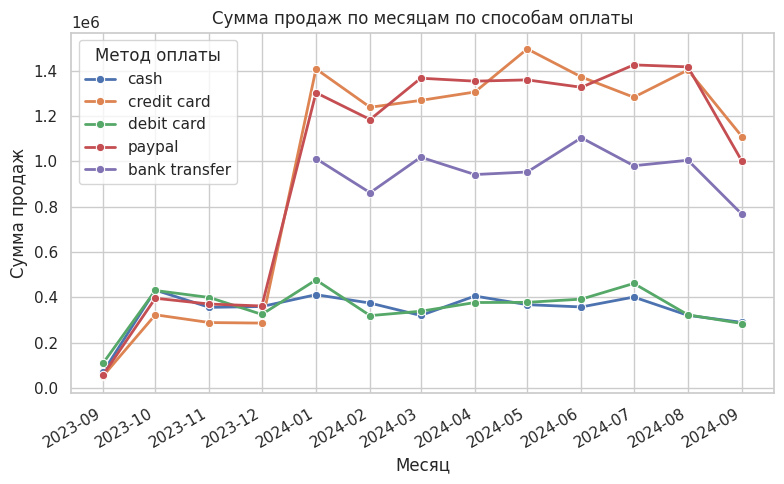

In [ ]:
sns.set_theme(style="whitegrid")

fig, ax = plt.subplots(figsize=(8, 5))

sns.lineplot(
    data=monthly_pm,
    x="month",
    y="Monthly Sales",
    hue="Payment Method",
    marker="o",
    ax=ax,
    linewidth=2,
)

# Заголовок и подписи осей
ax.set_title("Сумма продаж по месяцам по способам оплаты")
ax.set_xlabel("Месяц")
ax.set_ylabel("Сумма продаж")

# Форматирование оси X для отображения месяцев
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))

ax.xaxis.set_major_locator(mdates.MonthLocator())

# Поворот меток, чтобы не налезали
for label in ax.get_xticklabels():
    label.set_rotation(30)
    label.set_horizontalalignment("right")

# Заголовок легенды
ax.legend(title="Метод оплаты")

plt.tight_layout()
plt.show()

## Вывод
Исходя из данных можно сказать, что люди в основном предпочитают использовать пейпал и кредитки с 24 года, эти способы очень близки по количеству и сумме покупок на протяжении всего рассматриваемого периода. 

## Общие траты за весь период наблюдения по покупателю.

In [12]:
df["AgeQuartile"] = pd.qcut(
    df["Age"],
    q=4,
    labels=["Молодые", "Моложе среднего", "Старше среднего", "Старики"]
)

In [13]:
df.groupby(['AgeQuartile', 'Gender'], as_index=False)['Total_Spent_Row'].sum()

/tmp/ipykernel_27178/3867674454.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(['AgeQuartile', 'Gender'], as_index=False)['Total_Spent_Row'].sum()


,AgeQuartile,Gender,Total_Spent_Row
0,Молодые,Female,5563239.56
1,Молодые,Male,5432936.42
2,Моложе среднего,Female,5493146.17
3,Моложе среднего,Male,5540949.21
4,Старше среднего,Female,5433660.78
5,Старше среднего,Male,5744800.39
6,Старики,Female,5190681.90
7,Старики,Male,5065122.06


In [14]:
df.groupby(['Customer ID'], as_index=False)['Total_Spent_Row'].sum().sort_values(by='Total_Spent_Row', ascending=False).head(10)

,Customer ID,Total_Spent_Row
5048,11476,30136.35
7095,15399,29390.27
6177,13635,28481.39
7584,16357,27838.76
5489,12294,27052.70
4960,11332,26965.89
839,2556,26329.06
6124,13534,26261.21
8030,17236,25167.95
6589,14436,25014.73


## Вывод
Исходя из данных можно сказать, что поведение покупателей с возрастом и полом почти не отличается, выбросов почти нет возрастание очень ровное

## Сумма, потраченная на дополнительные услуги и аксессуары по каждому покупателю.

In [15]:
df_addon = df.groupby("Customer ID", as_index=False)["Add-on Total"]\
    .sum()\
    .rename(columns={"Add-on Total": "AddOn_Spent"})\
    .sort_values("AddOn_Spent", ascending=False)\
    


In [16]:
df_addon

,Customer ID,AddOn_Spent
7937,17054,658.32
7221,15648,640.44
5139,11669,613.83
5749,12780,595.63
4926,11270,580.85
...,...,...
4619,9741,0.00
4616,9736,0.00
4609,9713,0.00
4608,9711,0.00


In [17]:
df_addon['AddOn_Spent'].describe()

count    9466.000000
mean       88.273319
std        83.779929
min         0.000000
25%        26.105000
50%        71.490000
75%       127.497500
max       658.320000
Name: AddOn_Spent, dtype: float64

In [18]:
df.groupby(['AgeQuartile', 'Gender'], as_index=False)["Add-on Total"].sum()

/tmp/ipykernel_27178/3163072017.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(['AgeQuartile', 'Gender'], as_index=False)["Add-on Total"].sum()


,AgeQuartile,Gender,Add-on Total
0,Молодые,Female,111940.79
1,Молодые,Male,102129.18
2,Моложе среднего,Female,110208.44
3,Моложе среднего,Male,104497.15
4,Старше среднего,Female,105903.75
5,Старше среднего,Male,108250.62
6,Старики,Female,95759.40
7,Старики,Male,96905.91


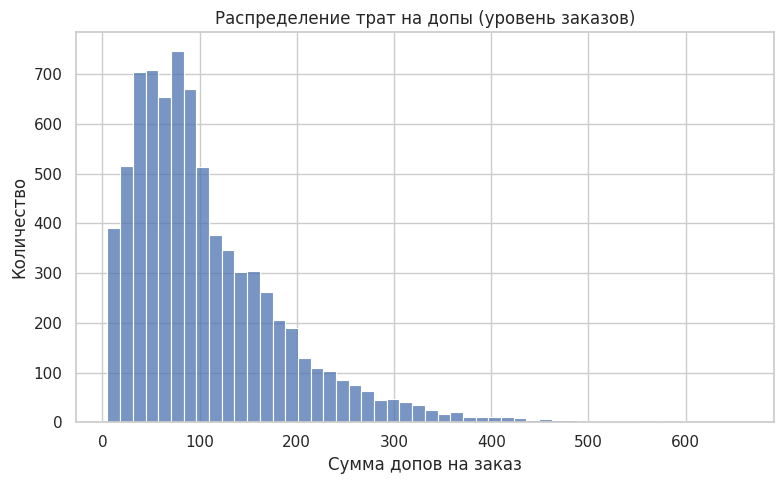

In [ ]:
fig, ax = plt.subplots(figsize=(8,5))

sns.histplot(
    data=df_addon[df_addon["AddOn_Spent"] > 0],
    x="AddOn_Spent",
    bins=50,           
    kde=False,
    ax=ax
)

ax.set_title("Распределение трат на допы (уровень заказов)")
ax.set_xlabel("Сумма допов на заказ")
ax.set_ylabel("Количество")


plt.tight_layout()
plt.show()

## Вывод
Исходя из данных можно сказать, допы люди любят брать допы чем моложе тем больше. Само возрастание суммы покупок допов очень ровное квантили растур равномерно.
Сумма в df_addon

In [21]:
total_price = df.groupby('Customer ID', as_index=False)['Total Price'].sum()
add_on_price = df.groupby('Customer ID', as_index=False)['Add-on Total'].sum()


In [22]:
product_price = df.groupby('Customer ID')\
    .apply(lambda g: g.groupby('Payment Method')['Total Price'].sum().to_dict()).reset_index(name='Product_Price_Dict')


/tmp/ipykernel_27178/2457679127.py:2: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.groupby('Payment Method')['Total Price'].sum().to_dict()).reset_index(name='Product_Price_Dict')


In [23]:
result = total_price.merge(add_on_price).merge(product_price)

In [24]:
result

,Customer ID,Total Price,Add-on Total,Product_Price_Dict
0,1000,741.09,26.09,{'paypal': 741.09}
1,1002,5020.60,60.16,"{'cash': 3164.76, 'credit card': 1855.84}"
2,1003,41.50,35.56,{'cash': 41.5}
3,1004,83.00,65.78,{'credit card': 83.0}
4,1005,11779.11,75.33,"{'debit card': 4175.64, 'paypal': 7603.47}"
...,...,...,...,...
9461,19990,9117.44,113.56,{'paypal': 9117.44}
9462,19991,12368.06,0.00,"{'credit card': 3250.62, 'paypal': 9117.44}"
9463,19995,5394.56,0.00,{'credit card': 5394.56}
9464,19996,12063.02,198.98,"{'bank transfer': 8643.98, 'credit card': 3419..."


# Вывод по заданию

Я в начале напутал и сделал не то но решил не удалять в result находится все что нужно по вопросу. Не рекомендую после 7 часов написания скриптов на баше садиться за аналитику(

# Задание 2

Вычислите показатели выручки (дохода) в разрезах логистики, ассортимента и доп. услуг за разные периоды, используя группировки и ресемплинг/агрегации.
Необходимые разрезы:

- По каждому методу доставки за весь рассматриваемый период.
- По каждому типу продукта с суммированием дохода.
- По дополнительным услугам помесячно для динамики по календарным месяцам.
- По дополнительным услугам поквартально для квартальных трендов.

Постройте визуализации для полученных агрегатов, отобразив их на графиках с корректными подписями осей и легендами.

##  Логистика: по методу доставки

In [25]:
rev_by_shipping = (
df.groupby(["Shipping Type", 'month'], as_index=False)["Total_Spent_Row"]
        .sum()
        .sort_values('month', ascending=False)
)

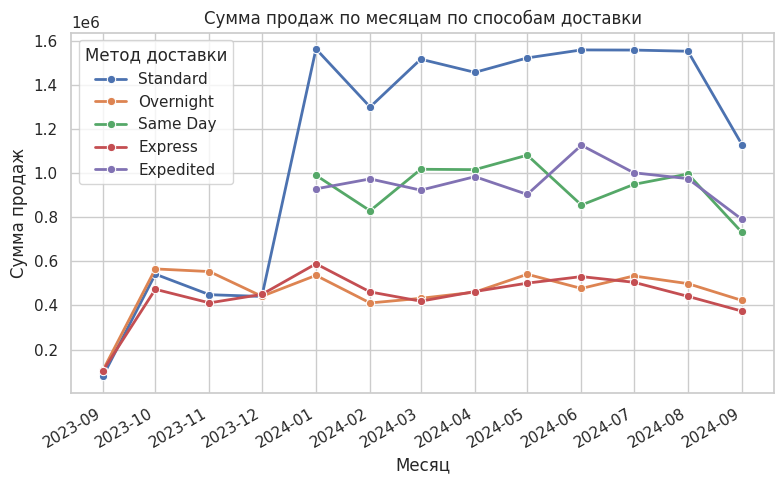

In [27]:
fig, ax = plt.subplots(figsize=(8, 5))

sns.lineplot(
    data=rev_by_shipping,
    x="month",
    y="Total_Spent_Row",
    hue="Shipping Type",
    marker="o",
    linewidth=2,
    ax=ax,
)

ax.set_title("Сумма продаж по месяцам по способам доставки")
ax.set_xlabel("Месяц")
ax.set_ylabel("Сумма продаж")

# Форматируем ось X как %Y-%m
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
ax.xaxis.set_major_locator(mdates.MonthLocator())

# Поворот меток, чтобы не налезали
for label in ax.get_xticklabels():
    label.set_rotation(30)
    label.set_horizontalalignment("right")

# Заголовок легенды
ax.legend(title="Метод доставки")

plt.tight_layout()
plt.show()

## Вывод
Большинство использует стандартный тип доставки начиная с 24 года, до этого все было довольно ровно. Тот же день и экспедиция появились с 24 года и сразу стали популярны.

## По каждому типу продукта с суммированием дохода.

/tmp/ipykernel_27178/3432171249.py:13: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




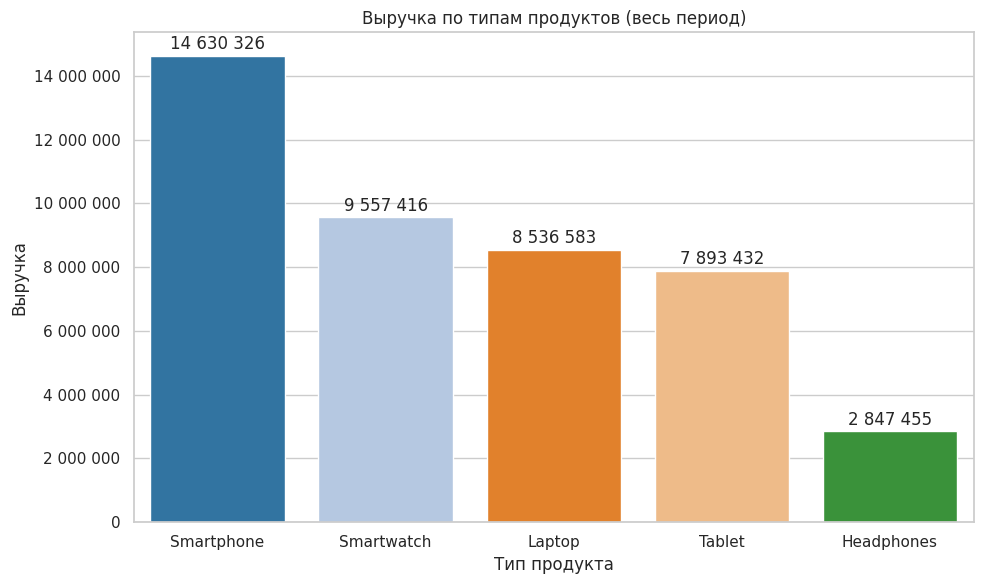

In [39]:
rev_by_product = (
    df.groupby("Product Type", as_index=False)["Total_Spent_Row"]
          .sum()
          .sort_values("Total_Spent_Row", ascending=False)
)


palette = sns.color_palette("tab20", n_colors=len(rev_by_product))

fig, ax = plt.subplots(figsize=(10, 6))

# Разные цвета через параметр palette (список цветов по порядку категорий)
sns.barplot(
    data=rev_by_product,
    x="Product Type",
    y="Total_Spent_Row",
    palette=palette,
    ax=ax,
)

ax.set_title("Выручка по типам продуктов (весь период)")
ax.set_xlabel("Тип продукта")
ax.set_ylabel("Выручка")



# Формат чисел с пробелами на оси Y
fmt_space = FuncFormatter(lambda x, p: format(int(round(x)), ",d").replace(",", " "))
ax.yaxis.set_major_formatter(fmt_space)

# Подписи значений над столбцами с пробелами
for container in ax.containers:
    labels = [format(v, ",.0f").replace(",", " ") for v in container.datavalues]
    ax.bar_label(container, labels=labels, label_type="edge", padding=2)

plt.tight_layout()
plt.show()

/tmp/ipykernel_27178/312096388.py:8: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




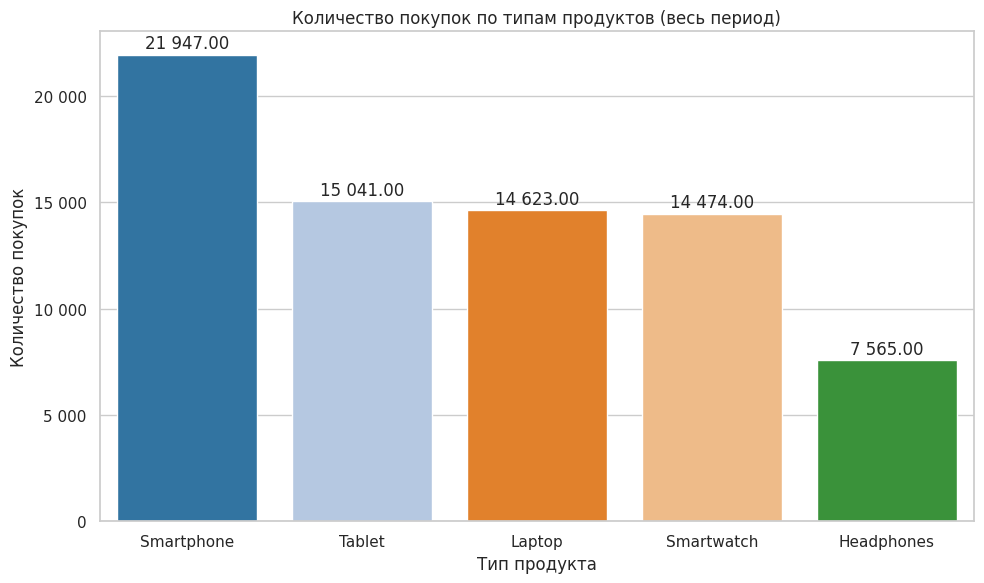

In [41]:
rev_by_product = (
    df.groupby("Product Type", as_index=False)["Quantity"]
          .sum()
          .sort_values("Quantity", ascending=False)
)
fig, ax = plt.subplots(figsize=(10, 6))

sns.barplot(
    data=rev_by_product,
    x="Product Type",
    y="Quantity",
    palette=palette,   # разные цвета столбцов
    ax=ax,
)

ax.set_title("Количество покупок по типам продуктов (весь период)")
ax.set_xlabel("Тип продукта")
ax.set_ylabel("Количество покупок")



# Формат оси Y: тысячи — пробелом
ax.yaxis.set_major_formatter(fmt_space)

# Подписи над столбцами: целые, с пробелами
for container in ax.containers:
    labels = [format(v, ",.2f").replace(",", " ") for v in container.datavalues]
    ax.bar_label(container, labels=labels, label_type="edge", padding=2)

# Аналог margin=dict(b=90): увеличить нижний отступ
plt.subplots_adjust(bottom=0.25)

plt.tight_layout()
plt.show()

## Вывод
Самым популярным продуктом по выручке являеются смартфоны, по количеству они тоже всех опережают. А вот, планшетов продаются больше, но по сумме их меньше чем часов и ноутбуков. Что довольно странно. 

## По дополнительным услугам помесячно для динамики по календарным месяцам и кварталам.

/tmp/ipykernel_27178/3425425496.py:33: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



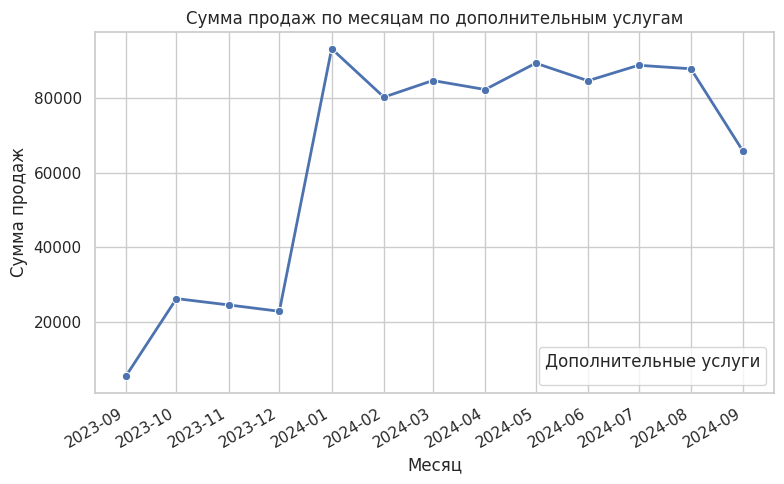

In [44]:
rev_by_addon = (
    df.groupby([ "month"], as_index=False)["Add-on Total"]
          .sum()
          .sort_values("month", ascending=False)
)

fig, ax = plt.subplots(figsize=(8, 5))

sns.lineplot(
    data=rev_by_addon,
    x="month",
    y="Add-on Total",
    marker="o",
    linewidth=2,
    ax=ax,
   
)

ax.set_title("Сумма продаж по месяцам по дополнительным услугам")
ax.set_xlabel("Месяц")
ax.set_ylabel("Сумма продаж")

# Формат оси X как %Y-%m и шаг по месяцам
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
ax.xaxis.set_major_locator(mdates.MonthLocator())

# Поворот меток времени
for label in ax.get_xticklabels():
    label.set_rotation(30)
    label.set_horizontalalignment("right")

# Заголовок легенды (появится при включении hue выше)
ax.legend(title="Дополнительные услуги", loc="best")

plt.tight_layout()
plt.show()

In [45]:
# Разбить строку на список категорий
def parse_addons(s):
    if pd.isna(s):
        return []
    # Нормализуем: сплит по запятой, strip пробелов
    items = [x.strip() for x in str(s).split(",") if x.strip()]
    return items

df["AddOn_List"] = df["Add-ons Purchased"].apply(parse_addons)

In [46]:

# Explode: одна строка на каждую категорию допа
df_exploded = df.explode("AddOn_List").reset_index(drop=True)
df_exploded = df_exploded[df_exploded["AddOn_List"].notna() & df_exploded["AddOn_List"].ne("")]

In [47]:
addon_counts = df_exploded["AddOn_List"].value_counts().reset_index()
addon_counts.columns = ["AddOn_Category", "Count"]

/tmp/ipykernel_27178/1421528130.py:3: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


/tmp/ipykernel_27178/1421528130.py:3: UserWarning:

The palette list has more values (5) than needed (3), which may not be intended.



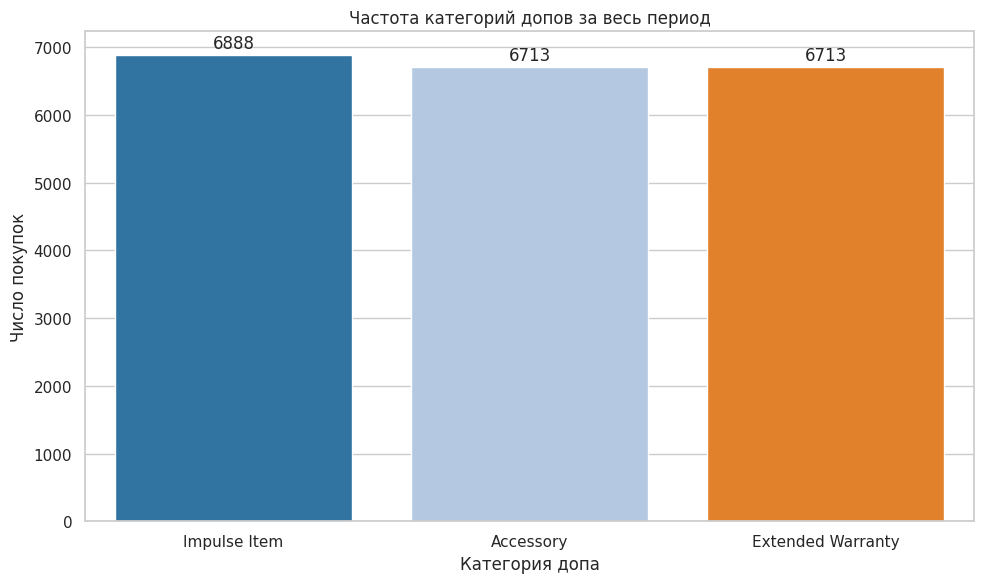

In [49]:

fig, ax = plt.subplots(figsize=(10, 6))

sns.barplot(
    data=addon_counts,
    x="AddOn_Category",
    y="Count",
    palette=palette,     # можно убрать, если нужен один цвет
    ax=ax,
)

ax.set_title("Частота категорий допов за весь период")
ax.set_xlabel("Категория допа")
ax.set_ylabel("Число покупок")


# Подписи над столбцами (целые значения)
for container in ax.containers:
    ax.bar_label(container, fmt="%.0f", label_type="edge", padding=2)

# Увеличить нижний отступ как margin=dict(b=90)
plt.subplots_adjust(bottom=0.25)

plt.tight_layout()
plt.show()

/tmp/ipykernel_27178/3795846932.py:32: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



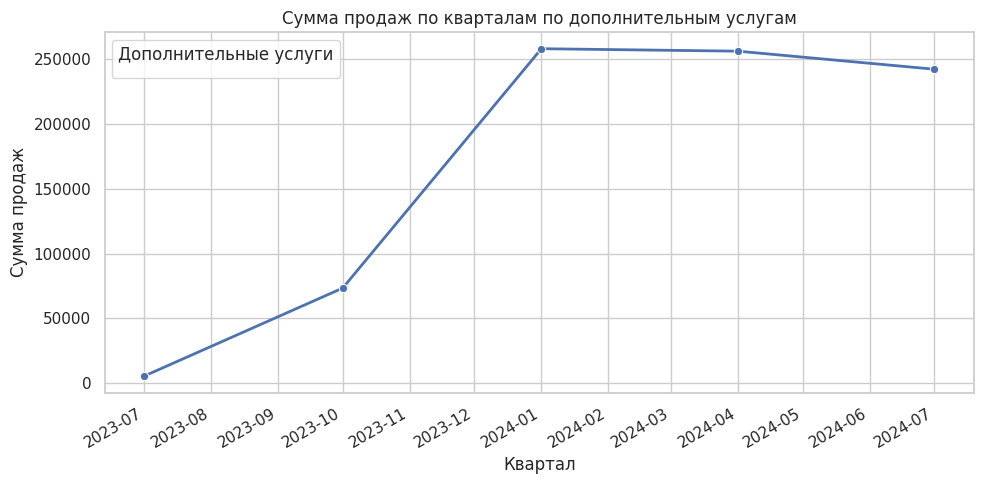

In [60]:
rev_by_addon_q = (
    df.groupby([ "quartal"], as_index=False)["Add-on Total"]
          .sum()
          .sort_values("quartal", ascending=False)
)
fig, ax = plt.subplots(figsize=(10, 5))

sns.lineplot(
    data=rev_by_addon_q,
    x="quartal",
    y="Add-on Total",
    marker="o",
    linewidth=2,
    ax=ax,
   
)

ax.set_title("Сумма продаж по кварталам по дополнительным услугам")
ax.set_xlabel("Квартал")
ax.set_ylabel("Сумма продаж")

# Формат оси X как %Y-%m и шаг по месяцам
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
ax.xaxis.set_major_locator(mdates.MonthLocator())

# Поворот меток времени
for label in ax.get_xticklabels():
    label.set_rotation(30)
    label.set_horizontalalignment("right")

# Заголовок легенды (появится при включении hue выше)
ax.legend(title="Дополнительные услуги", loc="best")

plt.tight_layout()

In [73]:
rev_by_addon_q

,quartal,Add-on Total
4,2024-07-01,242361.42
3,2024-04-01,256316.84
2,2024-01-01,258222.60
1,2023-10-01,73356.77
0,2023-07-01,5337.61


## Вывод
Резкий взлет продаж с начала 24 года, а дальше стаблильное небольшое падение. Так же равномерно распределены категории доп заказов, нет возможности посчитать точные суммы по ним, но скорее всего они тоже равномерны. 